# Title: Insurance Zones Creation Using Satellite Data Analysis

## Author: Elkana Kipruto

### Date: Saturday,10th May, 2025

In [ ]:
#import necessary modules and libraries
import pandas as pd
import geopandas as gpd
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from google.colab import files

## Prerequisites and function definition
### This code uses functions as much as possible to ensure reproducibility and scalability and it is in this section that the functions are defined.
This section covers:
- Setting up and authenticating the environment
- Importing the image collections and datasets

The functions defined are:
- Cloud masking function
- NDVI calculation function
- Vegetation masking function
- Classification function ( using ndvi thresholds to classify to cropland, wetland etc)
- UAI classification function (using interval of 0.2)

In [ ]:
# authenticate and initialize on my google projects
ee.Authenticate()
ee.Initialize(project = 'fill your credential here')

In [ ]:
#function to read in the shapefile from user and convert format
def read_shapefile():
  '''This function prompts user to upload a shapefile, reads it and converts it to ee object

  Returns:
  aoi - ee object of the shapefile
  '''
  uploaded = files.upload()
  file_path = next(iter(uploaded))
  shp = gpd.read_file(file_path)
  aoi = geemap.geopandas_to_ee(shp)
  return aoi

#now call the function
aoi = read_shapefile()

Saving bangweulu.dbf to bangweulu (1).dbf
Saving bangweulu.prj to bangweulu (1).prj
Saving bangweulu.qmd to bangweulu (1).qmd
Saving bangweulu.shp to bangweulu (1).shp
Saving bangweulu.shx to bangweulu (1).shx


#### Cloud masking function: Uses the cloud probability to mask out areas of with more than 40% confidence of being a cloud and then joins it with the image collection to create a mask

In [ ]:
#function to mask clouds
# Join function
def join_collections(col1, col2):
  '''
  Joins the cloud probability image collection with the sentinel 2 image collection

  Args:
  col1 - this is the sentinel 2 image collection
  col2 - this is the cloud probability image collection

  Returns:
  image collection - image collection joined with the cloud probability image collection
  '''
  filter_time_eq = ee.Filter.equals(leftField='system:index', rightField='system:index')
  return ee.Join.saveFirst("cloud_mask").apply( col1, col2,filter_time_eq )

def mask_clouds(img):
  '''
  Masks the clouds using the cloud probability image collection

  Args:
  img - image collection

  Returns:
  masked_img - image collection with clouds masked
  '''
  cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
  is_clear = cloud_prob.lt(40)  # threshold
  masked_img = img.updateMask(is_clear)
  return masked_img.copyProperties(img, img.propertyNames())

#### The NDVI calculation function - calculates ndvi on the image collection using the NIR and RED bands of Sentinel 2 and adds the NDVI to collection as a band

In [ ]:
#ndvi function
def add_ndvi(image):
  '''Calculates ndvi on the image collection and returns the ndvi as a band

  Args:
  image(image collecton) - sentinel 2 image collection

  Returns:
  image(image collection) - image collection with NDVI band added
  '''
  ndvi = image.normalizedDifference(['B8', 'B4']).rename('ndvi')
  return image.addBands(ndvi)

#### The edible vegetation mask which utilizes the ESA landcover to combine all land classes that classify as vegetation into one vegetation class that is then used as mask

In [ ]:
#function to use landcover to create a mask for all classes that qualify as vegetation
def vegetation_mask(image):
  '''Imports landcover image and creates a mask for all classes that qualify as vegetation

  Args:
  image(image object) - ESA landcover image for 2020

  Returns:
  vegetation mask - a binary mask of vegetation vs not vegetation that will be used to mask ndvi
  '''
  vegetation_classes = [
                        10, #tree cover
                        20, #shrubland
                        30, #grassland
                        40, #cropland
                        60, #sparse vegetation
                        90, #herbaceous wetland
                        95 #mangrove
  ]

  vegetation_mask =  image.remap(vegetation_classes, [1] * len(vegetation_classes)).rename('vegetation')
  return vegetation_mask

#### The classification of the vegetation into wetlands, shrubland, cropland and evergreen using thresholds along the NDVI scale

In [ ]:
#function to classify vegetation into cropland, wetlands, shrubland, and evergreen
def classified_vegetation(ndvi_image):
  '''Groups the vegetation into 4 classes by setting thresholds using the ndvi signatures to get wetlands, shrubland, cropland and evergreen

  Args:
  ndvi_image(image object) - mean ndvi image for 2020

  Returns:
  image - image with 4 vegetation classes
  '''
  ndvi_image.select('ndvi')
  wetlands = ndvi_image.gt(0.0).And(ndvi_image.lte(0.3)) #greater than 0 but less/equal to 0.3
  shrubland = ndvi_image.gt(0.3).And(ndvi_image.lte(0.5)) #greater than 0.3 but less/equal to 0.5
  cropland = ndvi_image.gt(0.5).And(ndvi_image.lte(0.7)) #greater than 0.5 but less/equal to 0.7
  evergreen = ndvi_image.gt(0.7) #greater than 0.7

  classified = (wetlands.multiply(1)
  .add(shrubland.multiply(2))
  .add(cropland.multiply(3))
  .add(evergreen.multiply(4))
  )

  return classified.rename('vegetation_class')

#### Classification into UAI zones using the 0.2 interval. Utilizes the reclassification method by using an expression

In [ ]:
#segmenting to homogenous zones in intervals of 0.2
#this means 5 classes from 0 to 1, just divide the masked ndvi by 5, bingo
def reclass_uai(image):
  '''Reclassifies the ndvi to create UAI zones

  Args:
  image - the masked ndvi image

  Returns:
  image - reclassified ndvi image having been divided into zones
  '''
  uai_zones = image.expression(
      "(b > 0.0 && b < 0.2) *1 + (b >= 0.2 && b < 0.4) *2 + (b >= 0.4 && b < 0.6) *3 + (b >= 0.6 && b < 0.8) *4 + (b >= 0.8) *5", {'b': image}
  ).rename('UAI_zones')

  return uai_zones

#### Now import the image collections and datasets that will be used with the above functions. Also applies the cloud masking

In [ ]:
#import sentinel 2 image collection, and apply ndvi function
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
.filterDate('2020-01-01', '2024-12-31')
.filterBounds(aoi)
.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80))
.map(add_ndvi)
.select('ndvi')
)

# Sentinel-2 cloud probability
s2_clouds = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY") \
    .filterDate("2020-01-01", "2024-12-31") \
    .filterBounds(aoi)



joined = ee.ImageCollection(join_collections(s2, s2_clouds)) #join the cloud probability with the sentinel 2 collection
masked_collection = ee.ImageCollection(joined).map(mask_clouds) #and then now mask the clouds by applying masking function



#ESA landcover dataset for 2020
landcover = ee.Image("ESA/WorldCover/v100/2020").clip(aoi) #esa landcover

## Using the functions to do the analysis

#### Average NDVI of 2020

In [ ]:
#average the ndvi over 2020
start = '2020-01-01'
end = '2020-12-31'
ndvi_mean_2020 = masked_collection.filterDate(start, end).mean()

#### Creating the vegetation mask

In [ ]:
mask = vegetation_mask(landcover).select('vegetation')

#now use the mask on the ndvi layer
masked_ndvi = ndvi_mean_2020.updateMask(mask)

#### Classify to wetlands, shrubland etc

In [ ]:
#call the function on the masked ndvi image
classified = classified_vegetation(masked_ndvi)

Classify to UAI zones based on the NDVI 0.2 interval

In [ ]:
uai_zones = reclass_uai(masked_ndvi)

#### Creating the NDVI time series for each UAI zone from 2020 to 2024

In [ ]:
#monthly time series 2020 to 2024 for each uai zone
dates = pd.date_range("2020-01-01", "2024-12-31", freq="MS")
features = []

for date in dates:
    image = masked_collection.filterDate(str(date.date()), str((date + pd.DateOffset(months=1)).date())).mean()
    image = image.updateMask(mask)

    # Group by UAI value and compute mean NDVI
    stats = image.addBands(uai_zones).reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName='UAI'),
        geometry=aoi,
        scale=500,
        maxPixels=1e13
    ).getInfo()

    for group in stats['groups']:
        features.append({
            'date': date,
            'UAI_NDVI': group['UAI'],
            'NDVI': group['mean']
        })

ndvi_uai_df = pd.DataFrame(features)

## Part 2: Using additional datasets

#### Funtion to reclassify the layers into zones based on their values

- This function was arrived at after considering the value ranges for each dataset in the next cells

In [ ]:
#reclassify the layers using the information we now have
##for precipitation
def precipitation_reclass(image):
  '''This function reclassifies the precipitation to create precipitation zones

  Args:
  image - the precipitation chirps image

  Returns:
  image - reclassified precipitation image having been divided into zones
  '''
  precipitation_zones = image.expression(
      "(b < 1000) * 1 + (b >= 1000 && b < 1090) * 2 + (b >= 1090 && b < 1180) * 3 + (b >= 1180) * 4", {'b': image}
  ).rename('precipitation_class')
  return precipitation_zones

##for leaf area index
def lai_reclass(image):
  '''This function reclassifies the LAI to create LAI zones

  Args:
  image - the LAI modis image

  Returns:
  image - reclassified LAI image having been divided into zones
  '''
  lai_zones = image.expression(
      "(b < 10) * 1 + (b >= 10 && b < 20) * 2 + (b >= 20 && b < 30) * 3 + (b >= 30) * 4", {'b': image}
  ).rename('lai_class')
  return lai_zones


##for soil moisture
def sm_reclass(image):
  '''This function reclassifies the soil moisture to create sm zones

  Args:
  image - the soil moisture NASA image

  Returns:
  image - reclassified SM image having been divided into zones
  '''
  sm_zones = image.expression(
      "(b < 10) * 1 + (b >= 10 && b < 11) * 2 + (b >= 11 && b < 12) * 3 + (b >= 12) * 4", {'b': image}
  ).rename('sm_class')
  return sm_zones


#### Function to normalize all layers to 0-1 so as to prepare them for MultiCriteria Decision Making so as to ensure consistency of range

In [ ]:
#normalize all layers to 0-1 before mcda
def normalize_lai(image):
  '''Normalizes lai layer range

  Args:
  image - the image layer

  Returns:
  image - normalized range of image
  '''
  lai_norm = image.unitScale(2, 50)
  return lai_norm

#normalize precipitation
def normalize_precip(image):
  '''Normalizes precip layer range

  Args:
  image - the image layer

  Returns:
  image - normalized range of image
  '''
  precip_norm = image.unitScale(916, 1380)
  return precip_norm


# normalize soil moisture
def normalize_sm(image):
  '''Normalizes sm layer range

  Args:
  image - the image layer

  Returns:
  image - normalized range of image
  '''
  sm_norm = image.unitScale(9, 15)
  return sm_norm

#normalize ndvi
def normalize_ndvi(image):
  '''Normalizes ndvi layer range

  Args:
  image - the image layer

  Returns:
  image - normalized range of image
  '''
  ndvi_norm = image.unitScale(0, 1)
  return ndvi_norm

#### Import the LAI, Precipitation, and Soil Moisture datasets

In [ ]:
lai = ee.ImageCollection('MODIS/061/MCD15A3H') \
        .filterDate('2020-01-01', '2020-12-31') \
        .select('Lai') \
        .mean().clip(aoi)

precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
            .filterDate('2020-01-01', '2020-12-31') \
            .select('precipitation') \
            .sum().clip(aoi)

soil_moisture = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture') \
                  .filterDate('2020-01-01', '2020-12-31') \
                  .select('ssm') \
                  .mean().clip(aoi)

#### View the stats of each dataset to get an idea of the thresholds to use later

- Prefer class interval of 10 so as to have approx 5 UAIs

- Prefer class interval of 1 to have 5 classes for soil moisture

- Prefer class interval of 90 to have 5 classes for precipitation

In [ ]:
geemap.image_stats(lai, aoi, 500).getInfo()
#max: 47.08
#min: 2.375
#mean: 11.48
#would prefer class interval of 10 so as to have approx 5 UAIs

{'max': {'Lai': 47.07954545454545},
 'mean': {'Lai': 11.482891832703565},
 'min': {'Lai': 2.375},
 'std': {'Lai': 3.8476393281257253},
 'sum': {'Lai': 305061.4842245992}}

In [ ]:
geemap.image_stats(precip, aoi, 500).getInfo()
#max: 1376.85
#min 916.32
#mean 1112.98
#would prefer class interval of 90 to have 5 classes

{'max': {'precipitation': 1376.8493893097593},
 'mean': {'precipitation': 1112.9758663755867},
 'min': {'precipitation': 916.3182463414986},
 'std': {'precipitation': 123.56290493107451},
 'sum': {'precipitation': 30445123.114249874}}

In [ ]:
geemap.image_stats(soil_moisture, aoi, 500).getInfo()
#max: 14.48
#min 9.28
#mean 10.79
#would prefer class interval of 1 to have 5 classes

{'max': {'ssm': 14.47999095916748},
 'mean': {'ssm': 10.789181045595866},
 'min': {'ssm': 9.282564163208008},
 'std': {'ssm': 0.9914755700688972},
 'sum': {'ssm': 295134.8319032181}}

#### Call the reclassification functions

In [ ]:
precipitation_class = precipitation_reclass(precip)
lai_class = lai_reclass(lai)
sm_class = sm_reclass(soil_moisture)

#### Call the normalization functions (0-1)

In [ ]:
#call the normalization functions
lai_norm = normalize_lai(lai)
precip_norm = normalize_precip(precip)
sm_norm = normalize_sm(soil_moisture)
ndvi_norm = normalize_ndvi(masked_ndvi)

#### Create weights for MCDA

##### Note:
- Weights have been chosen by me so could fail to reflect the real world importance of each variable, which could need expert input, PCA etc

In [ ]:
#weighted sum for the mcda where the weights indicate the importance of the layer
mcda_output = (ndvi_norm.multiply(0.5) #ndvi more important
.add(lai_norm.multiply(0.2)) #equal importance in lai and precip and least important is soil moisture
.add(precip_norm.multiply(0.2))
.add(sm_norm.multiply(0.1))
               )

In [ ]:
#now classify final mcda into uai zones
uai_mcda = mcda_output.expression(
    "(b > 0.0 && b < 0.2) * 1 + (b >= 0.2 && b < 0.4) * 2 + (b >= 0.4 && b < 0.6) * 3 + (b >= 0.6 && b < 0.8) * 4 + (b >= 0.8) * 5",
    {'b': mcda_output}
).rename('UAI_MCDA')

#### Obtain time series NDVI for the MCDA UAIs

In [ ]:
#now obtain ndvi time series for the mcda uais, just similar to part 1
#monthly time series 2020 to 2024 for each uai zone
dates = pd.date_range("2020-01-01", "2024-12-31", freq="MS")
features = []

for date in dates:
    image = masked_collection.filterDate(str(date.date()), str((date + pd.DateOffset(months=1)).date())).mean()
    image = image.updateMask(mask)

    # Group by UAI value and compute mean NDVI
    stats = image.addBands(uai_mcda).reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName='UAI'),
        geometry=aoi,
        scale=500,
        maxPixels=1e13
    ).getInfo()

    for group in stats['groups']:
        features.append({
            'date': date,
            'UAI_MCDA': group['UAI'],
            'NDVI': group['mean']
        })


ndvi_mcda_df = pd.DataFrame(features)

In [ ]:
ndvi_uai_df.head()

,date,UAI_NDVI,NDVI
0,2020-01-01,0,0.431488
1,2020-01-01,1,0.464645
2,2020-01-01,2,0.456370
3,2020-01-01,3,0.594125
4,2020-01-01,4,0.695781


In [ ]:
ndvi_mcda_df.head()

,date,UAI_MCDA,NDVI
0,2020-01-01,1,0.354200
1,2020-01-01,2,0.514989
2,2020-01-01,3,0.598676
3,2020-01-01,4,0.628437
4,2020-02-01,1,0.111963


#### Plot the timeseries of the NDVI

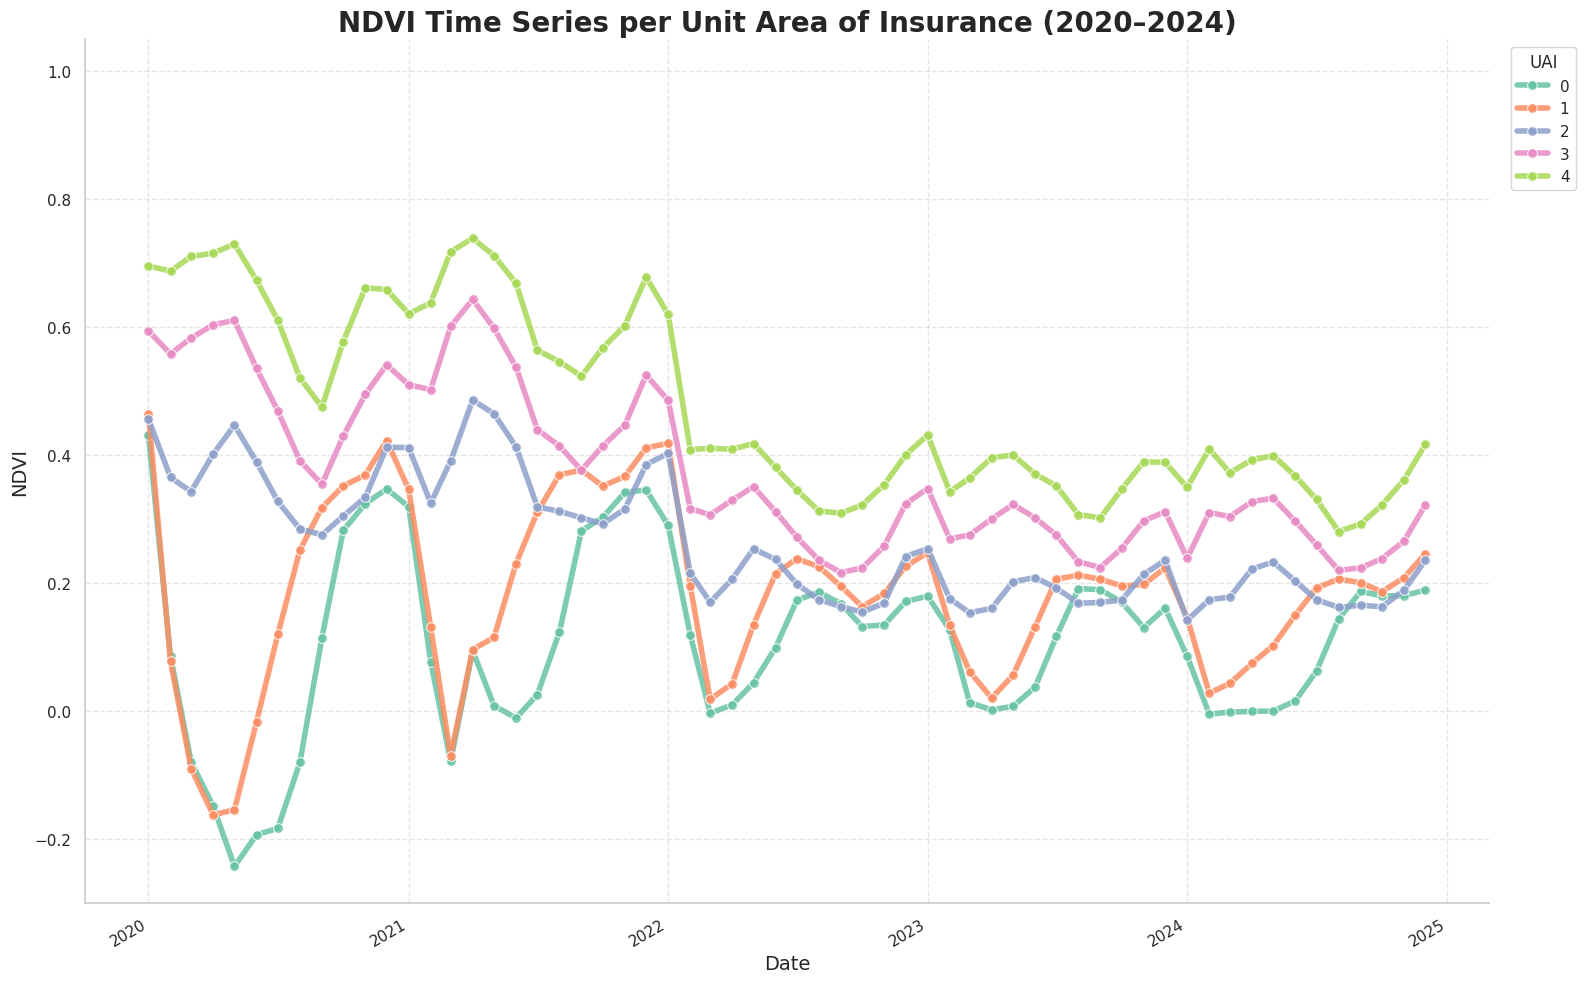

In [ ]:

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# Set seaborn theme
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 10))

# color palette
palette = sns.color_palette("Set2", n_colors=ndvi_uai_df["UAI_NDVI"].nunique())

# Plot with markers
sns.lineplot(
    data=ndvi_uai_df,
    x="date",
    y="NDVI",
    hue="UAI_NDVI",
    palette=palette,
    estimator=None,
    lw=4,
    marker="o",
    markersize=7,
    alpha=0.85,
    ax=ax
)


# Titles and labels
ax.set_title("NDVI Time Series per Unit Area of Insurance (2020–2024)", fontsize=20, weight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("NDVI", fontsize=14)
ax.set_ylim(-0.3, 1.05)

# ImprovING x-axis formatting
ax.tick_params(axis='x', rotation=45)
fig.autofmt_xdate()

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Move legend outside
ax.legend(title="UAI", bbox_to_anchor=(1.01, 1), loc="upper left", frameon=True)

# Save FIG
plt.tight_layout()
plt.savefig("ndvi_only_timeseries.png", dpi=300)
plt.show()


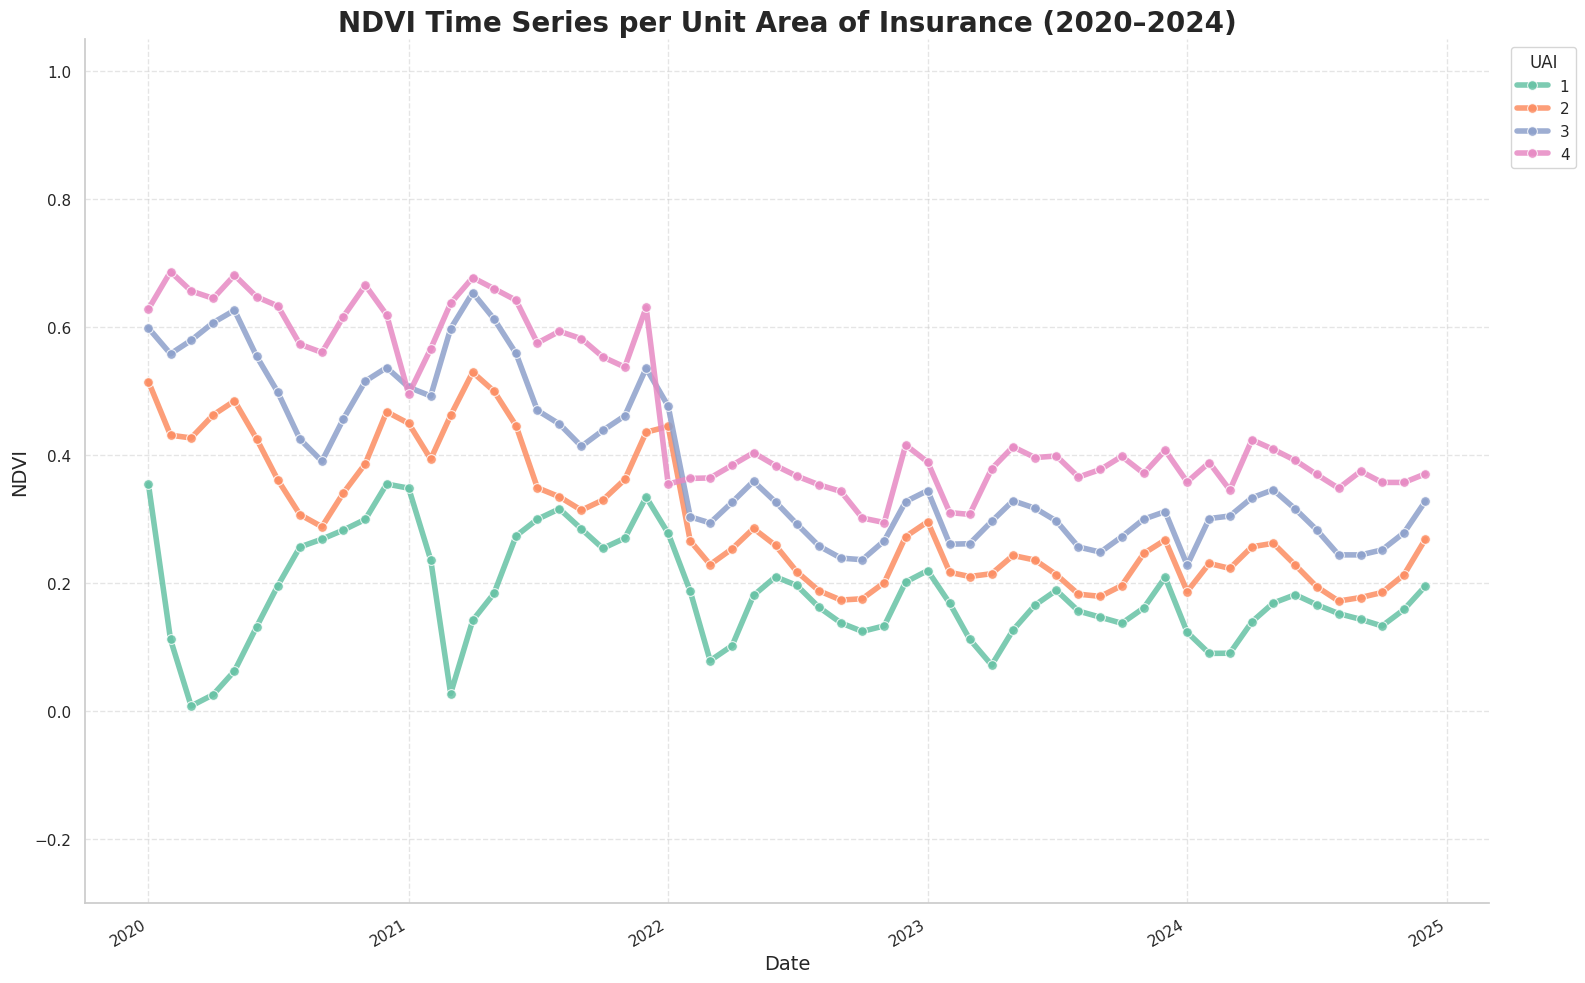

In [ ]:

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# Set seaborn theme
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(16, 10))

# color palette
palette = sns.color_palette("Set2", n_colors=ndvi_mcda_df["UAI_MCDA"].nunique())

# Plot with markers
sns.lineplot(
    data=ndvi_mcda_df,
    x="date",
    y="NDVI",
    hue="UAI_MCDA",
    palette=palette,
    estimator=None,
    lw=4,
    marker="o",
    markersize=7,
    alpha=0.85,
    ax=ax
)


# Titles and labels
ax.set_title("NDVI Time Series per Unit Area of Insurance (2020–2024)", fontsize=20, weight='bold')
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("NDVI", fontsize=14)
ax.set_ylim(-0.3, 1.05)

# ImprovING x-axis formatting
ax.tick_params(axis='x', rotation=45)
fig.autofmt_xdate()

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)
sns.despine()

# Move legend outside
ax.legend(title="UAI", bbox_to_anchor=(1.01, 1), loc="upper left", frameon=True)

# Save FIG
plt.tight_layout()
plt.savefig("ndvi_mcda_timeseries.png", dpi=500)
plt.show()


### Initialize map object and visualize the layers

In [ ]:
Map = geemap.Map() #initialize map object
Map.centerObject(aoi, 10) #center over Bangweulu
Map.add_basemap('HYBRID')#basemap

Map.addLayer(ndvi_mean_2020, {'min': 0, 'max': 1, 'palette': ['red', 'orange', 'green']}, 'Mean NDVI in 2020') #mean ndvi 2020
Map.addLayer(aoi, {}, 'Bangweulu') #the shapefile
Map.addLayer(landcover, {}, 'ESA WorldCover 2020') #landcover 2020
Map.addLayer(masked_ndvi, {'min':0, 'max':1, 'palette': ['red', 'orange', 'green']}, 'NDVI masked by vegetation') #masked ndvi
Map.addLayer(classified, {'min':1, 'max':4, 'palette': ['blue', 'red', 'yellow', 'green']}, 'Vegetation by class') #classified vegetation wetlands, shrub etc
Map.addLayer(uai_zones.select('UAI_zones'), {'min':0, 'max':4, 'palette': ['blue', 'red', 'brown', 'yellow', 'green']}, 'UAI NDVI Zones') # uai zones
Map.addLayer(mcda_output, {'min':0, 'max':4, 'palette': ['blue', 'red', 'brown', 'yellow', 'green']}, 'UAI MCDA Zones') # uai zones
Map #call the object

Map(center=[-11.926656401530163, 30.348169834374914], controls=(WidgetControl(options=['position', 'transparen…

### Export layers for external visualization


In [ ]:
#export to drive
geemap.ee_export_image_to_drive(
    image=mask,                     # ee.Image
    description='',      # Task name
    fileNamePrefix='',          # Name of exported file
    region=aoi.geometry(),                     # AOI to clip the image
    scale=10,                                  # Resolution
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)